In [3]:
# データの用意
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
x_train = np.empty([0, 224, 224, 3])
y_train = np.empty([0])
IMG_SIZE = 224
for i in range(15):
    files = glob.glob(f'datas/major_org/{i}/*.jpg')
    imgs = np.array([img_to_array(load_img(f, color_mode='rgb', target_size=(IMG_SIZE,IMG_SIZE))) for f in files])
    labels = np.array([i for f in files])

    x_train = np.r_[x_train, imgs]
    y_train = np.r_[y_train, labels]

files = glob.glob(f'datas/tests/*.jpg')
x_test = np.array([img_to_array(load_img(f, color_mode='rgb', target_size=(IMG_SIZE,IMG_SIZE))) for f in files])
y_test = np.array([int(f.replace('datas/tests\\', '').replace('.jpg', '')) for f in files])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
# データセットの大きさ確認
print(x_train.shape) # 訓練データのサイズ
print(y_train.shape) 
print(x_test.shape) # テストデータのサイズ
print(y_test.shape)

(216, 224, 224, 3)
(216, 15)
(15, 224, 224, 3)
(15, 15)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


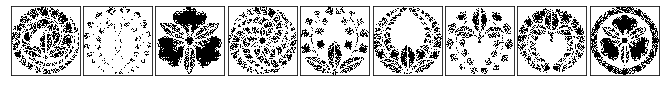

In [5]:
# データセットの表示
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]), cmap='gray')

### 4.2 実装

In [26]:
# モデル構築 ふんわりCNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D

model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same', input_shape=(120, 120, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(364, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# 出力層
model.add(Dense(15, activation='softmax'))

model.compile(loss="categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [14]:
# モデル構築 DenseNet
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
base_model = densenet.DenseNet121(include_top=False, weights='imagenet', classes=1000)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(15, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [15]:
# 学習
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# data augmentationの設定
params = {
    'rotation_range': 20,
    'width_shift_range':0.3,
    'height_shift_range':0.3
}
datagen = image.ImageDataGenerator(**params)
datagen.fit(x_train)

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024), epochs=100, callbacks=[early_stopping])
# model.fit(x_train, y_train, batch_size=100, verbose=2, epochs=30, validation_split=0.1, callbacks=[early_stopping])

0
1/1 [==============================] - 350s 350s/step - loss: 2.6070 - accuracy: 0.1806
Epoch 5/1000
1/1 [==============================] - 350s 350s/step - loss: 2.4989 - accuracy: 0.2130
Epoch 6/1000
1/1 [==============================] - 355s 355s/step - loss: 2.3862 - accuracy: 0.2407
Epoch 7/1000
1/1 [==============================] - 356s 356s/step - loss: 2.3019 - accuracy: 0.2685
Epoch 8/1000
1/1 [==============================] - 370s 370s/step - loss: 2.2055 - accuracy: 0.2500
Epoch 9/1000
1/1 [==============================] - 382s 382s/step - loss: 2.1826 - accuracy: 0.2917
Epoch 10/1000
1/1 [==============================] - 368s 368s/step - loss: 2.1717 - accuracy: 0.2593
Epoch 11/1000
1/1 [==============================] - 380s 380s/step - loss: 2.0381 - accuracy: 0.3102
Epoch 12/1000
1/1 [==============================] - 383s 383s/step - loss: 1.9924 - accuracy: 0.3287
Epoch 13/1000
1/1 [==============================] - 383s 383s/step - loss: 1.9297 - accuracy: 0.39

In [19]:
# 性能評価
score = model.evaluate(x_test, y_test, verbose=0)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[64.25955963134766, 0.06666667]
Test loss: 64.25955963134766
Test accuracy: 0.06666667


dict_keys(['loss', 'accuracy'])


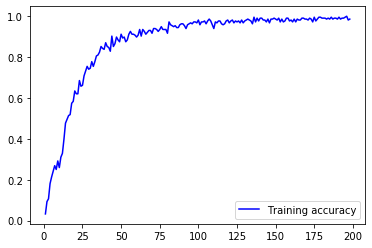

In [17]:
# 経過確認
import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.legend()
plt.show()

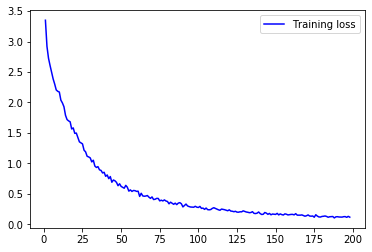

In [18]:
loss = history.history['loss']
epochs = range(1, len(loss)+1 )
plt.plot(epochs, loss, 'b', label='Training loss')
plt.legend()
plt.show()